# Исследование данных по полетам и билетам


# Введение.
По итогу прошлых шагов, где был задействован SQL, мною были получены две таблицы:
1) По самолетам (модель и количество рейсов на этих моделях)
2) По городам (наименование городов и среднее количество рейсов, прибывающих в город city за день в августе 2018 года)

### План:
1) Импортировать все библиотеки, что известны мне на данный момент (могут все и не понадобиться, но лишним не будет).

2) Импортировать данные и проверить на типы данных, отсутствующие значения, дубликаты и т.п.
    * Если есть, то всё поправить.
3) Выбрать топ-10 городов по количеству рейсов.

4) построить графики: 
    * модели самолетов 
    * количество рейсов, 
    * города и количество рейсов, 
    * топ-10 городов и количество рейсов
5) Оформить выводы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs


In [2]:
data1 = pd.read_csv('/datasets/query_1.csv')
display(data1.head(20))

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [4]:
data1.duplicated().sum()

0

In [5]:
data2 = pd.read_csv('/datasets/query_3.csv')
display(data2.head(20))

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
5,Барнаул,2.612903
6,Белгород,6.000000
7,Белоярский,2.000000
8,Благовещенск,1.000000
9,Братск,1.000000


In [6]:
data2['average_flights'] = data2['average_flights'].replace(r'\s+','',regex=True).astype('float')

In [7]:
data2.duplicated().sum()

0

In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [9]:
for item in [data1,data2]:
    item.info()
    item.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


Ничего изменять / заполнять не нужно

#### ТОП 10 городов по количеству рейсов

In [10]:
data2.groupby('city')['average_flights'].sum().to_frame('average_flights').sort_values(by='average_flights', ascending=False).head(10)

,average_flights
city,
Москва,129.774194
Санкт-Петербург,31.161290
Новосибирск,17.322581
Красноярск,11.580645
Екатеринбург,11.322581
Ростов-на-Дону,10.193548
Пермь,10.129032
Брянск,10.000000
Сочи,9.612903


Итак, у нас получается вполне ожидаемый результат:

ТОП 3:

1) Москва

2) СПб

3) Новосибирск 

Но здесь также видно, что не все города миллионники попали в список.
Начиная с Брянска количество жителей в городах на последних местах топа составляет ~400 тыс. человек и скорее всего они в этих городах чаще используются межгородние малогабаритные самолеты.

#### Таблицы

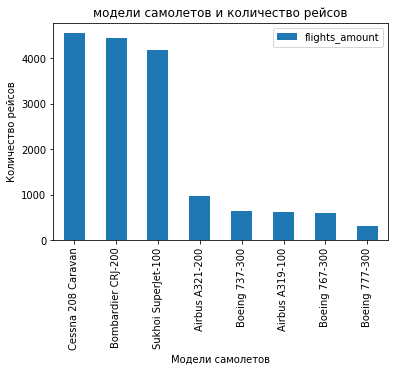

In [11]:
data1.groupby(by='model').agg({'flights_amount':'sum'}).sort_values(by='flights_amount', ascending=False).head(10).plot(kind='bar')
plt.title('модели самолетов и количество рейсов')
plt.xlabel('Модели самолетов')
plt.ylabel('Количество рейсов')
plt.show()

Ну вот как я говорил, малогабаритные самолеты обогнали по количеству вылетов гигантов Боинга и Аиробуса. В данном случае унас есть два фаворита: 

    * Ультракомпактный: cessna 208 caravan на 14-15 мест (не считая двух пилотов), 
    * Региональный bombardier crj-200, который часто юзает Utair, гоняя по Уралу и Поволжью, он 50 мест.

Кстати, вот так выглядит cessna 208 caravan:

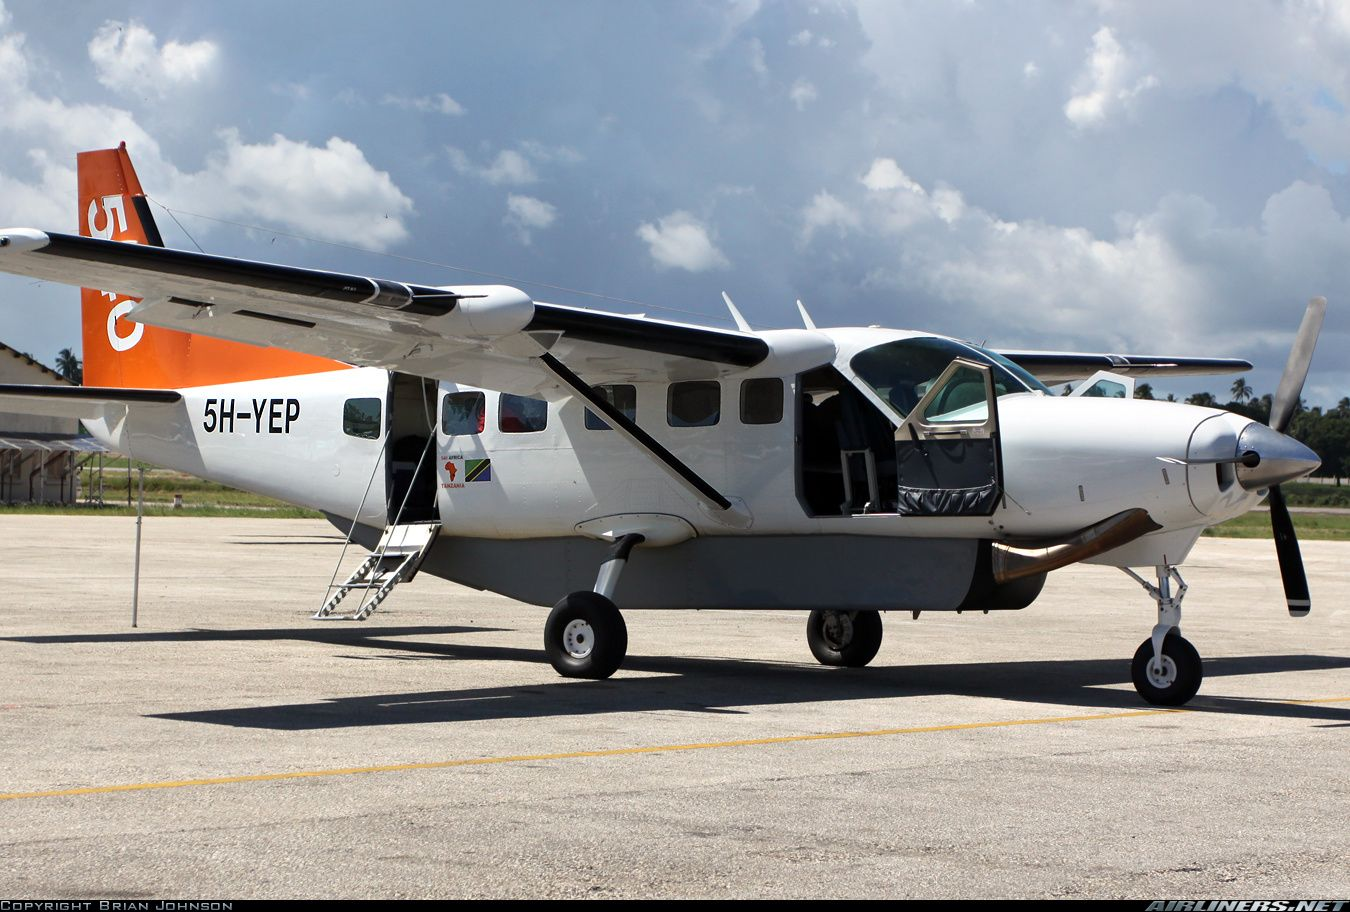


<hr style="border: 10px solid green;" />

#### Доп. задание.
* Посмотрим на корреляцию количества рейсов и населения города.
* Выдвину гипотезу о том, что все самолеты летают всегда полностью загруженными пассажирами, + можно оценить пассажиропоток по моделям самолетов

In [12]:
#обогатим данные, получив информацию о населении городов со стороннего ресурса
#спарсим данные как таблицу
url = 'http://www.statdata.ru/largest_cities_russia'
dfs = pd.read_html(url)
population = dfs[1]
#удалим лишние данные
population = population.iloc[14:].reset_index(drop = True)
population = population.drop([0, 1, 4, 5, 6, 7], axis=1)
population = population.dropna()
#переименуем столбцы
population.columns = ['city', 'population']
#удалим лишние данные
population = population[(population['city'] != 'Итого:') & (population['city'] != 'Город')]
#удалим "г." перед названиями городов
population['city'] = population['city'].map(lambda x: x.lstrip('г.'))
population['city'] = population['city'].map(lambda x: x.lstrip(' '))
#удалим пробелы в числах и приведем данные к целочисленным значениям
population['population'] = population['population'].replace(r'\s+','',regex=True).astype('int')
#проверим
display(population.head(50))
population.info()

,city,population
0,Москва,12678079
1,Санкт-Петербург,5398064
2,Новосибирск,1625631
3,Екатеринбург,1493749
4,Казань,1257391
5,Нижний Новгород,1252236
6,Челябинск,1196680
7,Самара,1156659
8,Омск,1154507
9,Ростов-на-Дону,1137904


<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 0 to 180
Data columns (total 2 columns):
city          173 non-null object
population    173 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


###### Корреляция количества рейсов и населения.

In [13]:
#объединю две таблицы для удобства
data3=data2.merge(population,how='left',on='city')
data3.head(50)

,city,average_flights,population
0,Абакан,3.870968,186797.0
1,Анадырь,1.000000,NaN
2,Анапа,2.161290,NaN
3,Архангельск,5.354839,346979.0
4,Астрахань,2.451613,529793.0
5,Барнаул,2.612903,632391.0
6,Белгород,6.000000,394142.0
7,Белоярский,2.000000,NaN
8,Благовещенск,1.000000,226385.0
9,Братск,1.000000,226269.0


In [14]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
city               101 non-null object
average_flights    101 non-null float64
population         77 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.2+ KB


после объединения таблиц появились пустые данные, которые нельзя было обрабоать ни вычислением средних показателей, ни вычислением медианы. Поэтому мной было принято решение удалить те данные, где пристутвуют пропуски. :(

In [15]:
data3=data3.dropna()

In [16]:
data3.head(50)


,city,average_flights,population
0,Абакан,3.870968,186797.0
3,Архангельск,5.354839,346979.0
4,Астрахань,2.451613,529793.0
5,Барнаул,2.612903,632391.0
6,Белгород,6.000000,394142.0
8,Благовещенск,1.000000,226385.0
9,Братск,1.000000,226269.0
10,Брянск,10.000000,402675.0
12,Владивосток,3.000000,606561.0
13,Владикавказ,2.000000,303597.0


In [17]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 100
Data columns (total 3 columns):
city               77 non-null object
average_flights    77 non-null float64
population         77 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.4+ KB


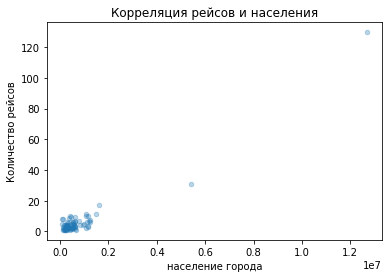

In [18]:
data3.plot(kind = 'scatter', y = 'average_flights', x = 'population', alpha = 0.3)

data3['population'].corr(data3['average_flights'])
plt.title('Корреляция рейсов и населения')
plt.xlabel('население города')
plt.ylabel('Количество рейсов')
plt.show()

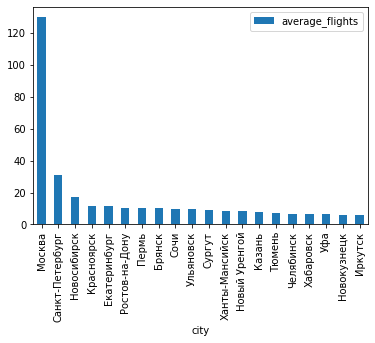

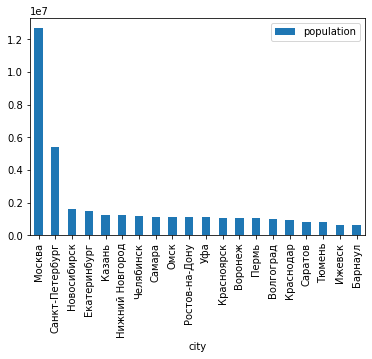

In [19]:
data3.groupby(by='city').agg({'population':'sum'}).sort_values(by='population', ascending=False).head(20).plot(kind='bar') 


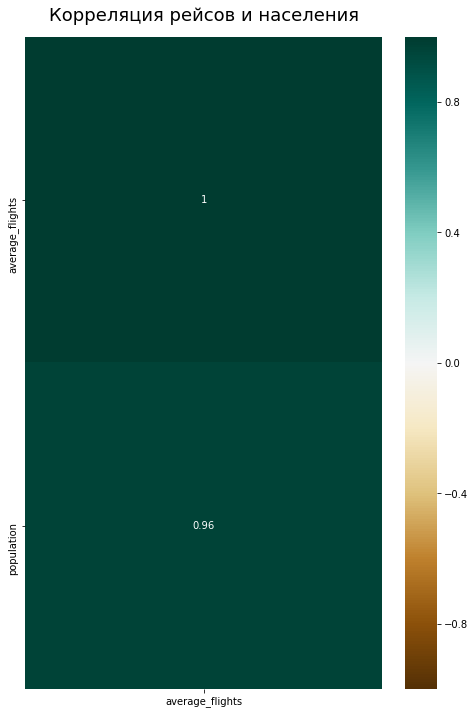

In [20]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data3.corr()[['average_flights']].sort_values(by='average_flights', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Корреляция рейсов и населения', fontdict={'fontsize':18}, pad=16);


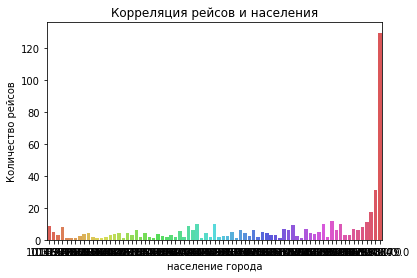

In [21]:
sns.barplot(x = 'population', y = 'average_flights', data = data3,
            palette = 'hls',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

plt.title('Корреляция рейсов и населения')
plt.xlabel('население города')
plt.ylabel('Количество рейсов')
plt.show()

###### Вывод:
Каких-то пародоксальных итогов нет, тут всё логично, чем больше людей, тем больше летают, есть несколько особенных случаев: Брянск, Ульяновск, Сургут, Ханты-Мансийск - но как было выявлено выше, там больше задействуют малогабаритные самолеты, т.к. логично, что большие самолеты были бы убыточными в содержании и эксплутации на маленькие дистанции.

##### Гипотеза: Все самолеты всегда летают предельно загруженные.

In [22]:
#т.к. присутствует всего 7 моделей, то я внесу данные вручную
df = pd.DataFrame(data1)
number_of_seats = ['156','185','149','336','550','50','15','95']
df['number_of_seats'] = number_of_seats
df

,model,flights_amount,number_of_seats
0,Airbus A319-100,607,156
1,Airbus A321-200,960,185
2,Boeing 737-300,630,149
3,Boeing 767-300,600,336
4,Boeing 777-300,300,550
5,Bombardier CRJ-200,4446,50
6,Cessna 208 Caravan,4557,15
7,Sukhoi SuperJet-100,4185,95


In [23]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
model              8 non-null object
flights_amount     8 non-null int64
number_of_seats    8 non-null object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [24]:
data1['number_of_seats'] = data1['number_of_seats'].replace(r'\s+','',regex=True).astype('int')

Н0: Все самолеты всегда летают предельно загруженные.

Н1: Все самолеты летают с неполной загруженностью.

In [25]:
alpha = .05
need_numbers = data1['number_of_seats'].mean()
result=st.ttest_1samp(data1['number_of_seats'],need_numbers)
print('P-value:',result.pvalue/2)
if (result.pvalue/2<alpha) and (data1['number_of_seats'].mean()>=need_numbers):
     print('Отвергаем нулевую гипотезу')
else:
    print('Не получилость отвергнуть нулевую гипотезу')

P-value: 0.5
Не получилость отвергнуть нулевую гипотезу


In [26]:
df = pd.DataFrame(data1)
amount_of_passengers=data1['flights_amount']*data1['number_of_seats']
df['amount_of_passengers']=amount_of_passengers

In [27]:
data1.head(10)

,model,flights_amount,number_of_seats,amount_of_passengers
0,Airbus A319-100,607,156,94692
1,Airbus A321-200,960,185,177600
2,Boeing 737-300,630,149,93870
3,Boeing 767-300,600,336,201600
4,Boeing 777-300,300,550,165000
5,Bombardier CRJ-200,4446,50,222300
6,Cessna 208 Caravan,4557,15,68355
7,Sukhoi SuperJet-100,4185,95,397575


In [28]:
data1['amount_of_passengers'] = data1['amount_of_passengers'].replace(r'\s+','',regex=True).astype('int')

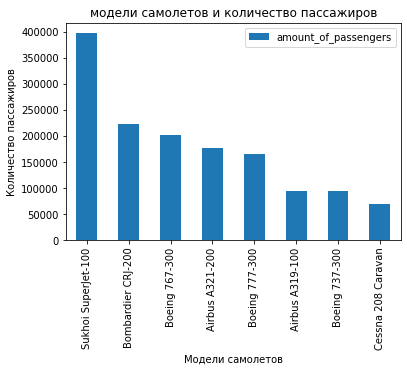

In [29]:
data1.groupby(by='model').agg({'amount_of_passengers':'sum'}).sort_values(by='amount_of_passengers', ascending=False).head(10).plot(kind='bar')
plt.title('модели самолетов и количество пассажиров')
plt.xlabel('Модели самолетов')
plt.ylabel('Количество пассажиров')
plt.show()

##### Вывод:
1. Я вручную ввел показатели количества мест в самолетах, т.к. данные были с разнуых сайтов.
2. Получилось, что в основном самолеты летают полностью загруженные.
3. На момент времени таблицы я расчитал общее количество пассажиров, которые самолеты рахных моделей, исходя из количества их мест, смогли перевести.
    * Оказалось, что Cessna Caravan, хоть и часто летает, но из-за маленького набора пассажирских мест смог перевести меньшее количество пассажиров, что логично.
    * Но bombardier crj-200 оказался на втором месте.
    * Логично, что боинги, хоть и имеют высокую вместимость, но летают только в "особых" случаях: заграницу, например.

<hr style="border: 10px solid green;" />

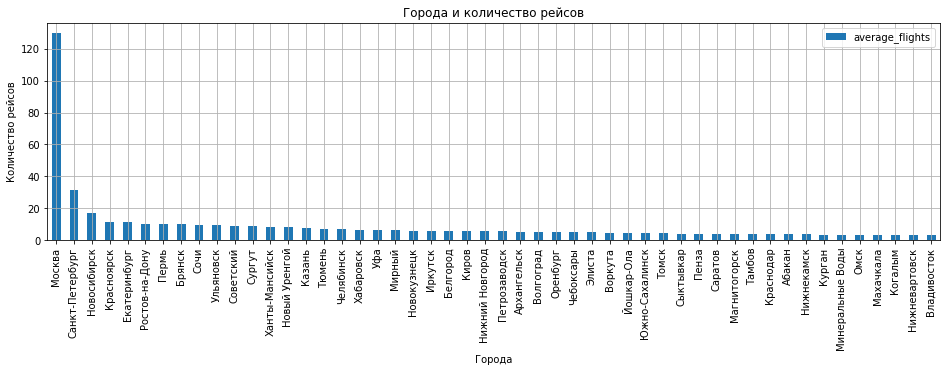

In [30]:
plot_city = data2.sort_values(by='average_flights', ascending=False).head(50)
plot_city.plot(x='city', grid=True, kind='bar', figsize=(16, 4), title='График количества рейсов по городам')
plt.title('Города и количество рейсов')
plt.xlabel('Города')
plt.ylabel('Количество рейсов')
plt.show()

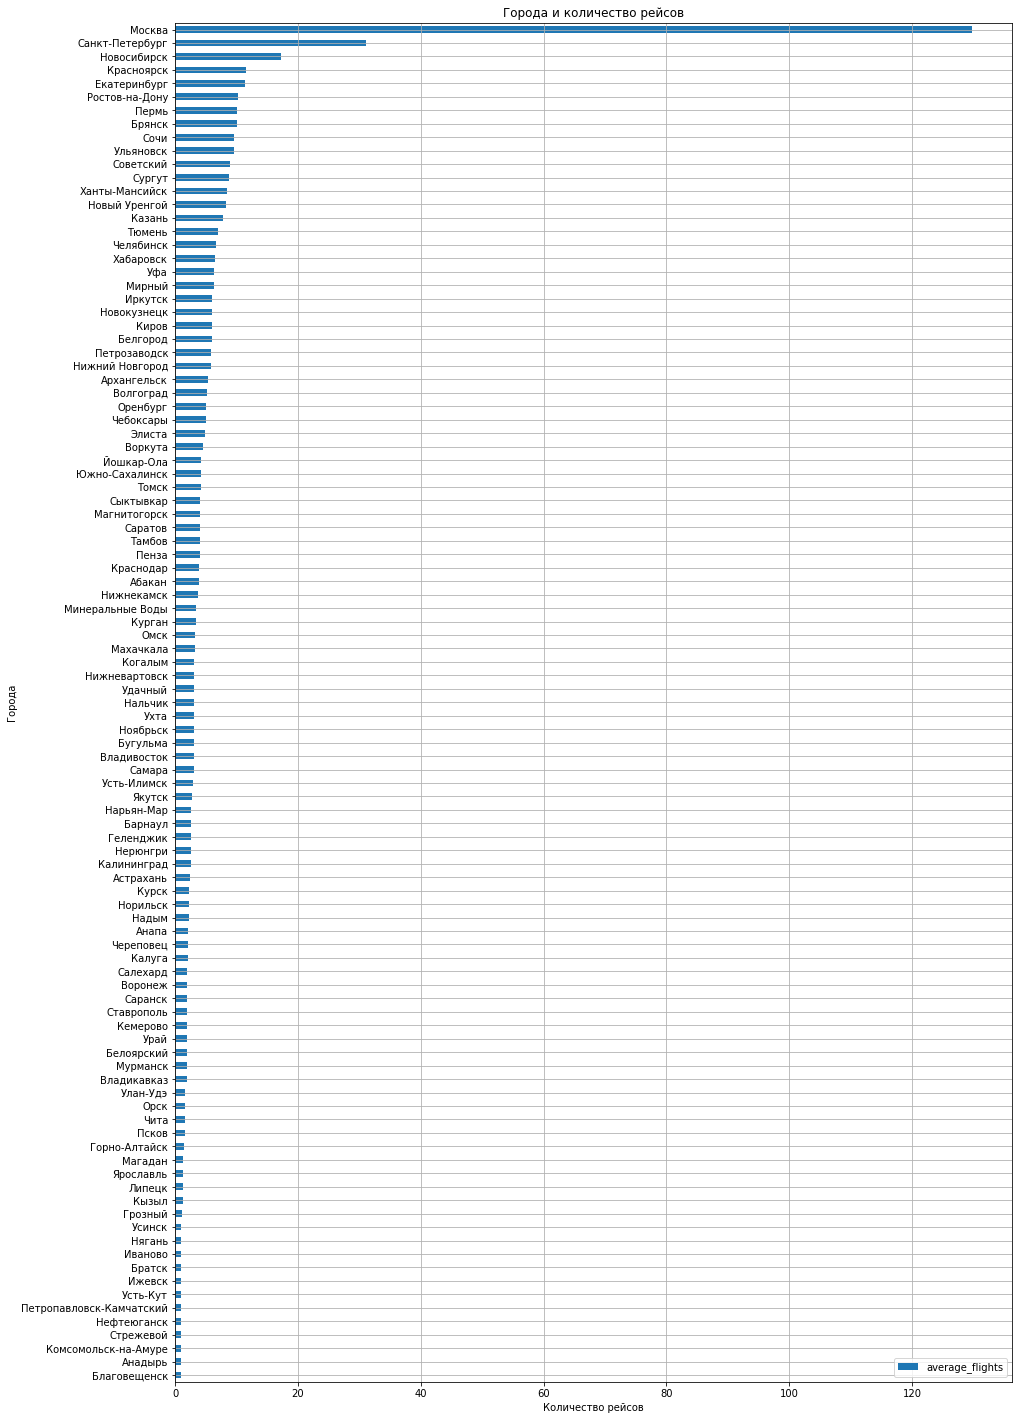

In [31]:
plot_city = data2.sort_values(by='average_flights', inplace=False)
plot_city.plot(x='city', grid=True, kind='barh', figsize=(15, 25), title='График количества рейсов по городам')
plt.title('Города и количество рейсов')
plt.xlabel('Количество рейсов')
plt.ylabel('Города')
plt.show()

Тут ожидаемо, что вошли города миллионники. Также в ТОП 10 вошли города, которые часто используют малогабаритные самолеты (их легче содержать и эксплуатировать, а также спрос на обалстные полеты еще никто не отменял).

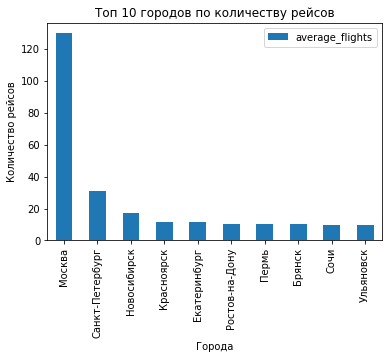

In [32]:
data2.groupby(by='city').agg({'average_flights':'sum'}).sort_values(by='average_flights', ascending=False).head(10).plot(kind='bar')
plt.title('Топ 10 городов по количеству рейсов')
plt.xlabel('Города')
plt.ylabel('Количество рейсов')
plt.show()

Тут всё тоже самое, что и в таблице по ТОП 10 городам. Ожидаемо, что Москва и СПб на первых двух местах. Вплоть до 7-го места города миллионники, а дальше, необычно, вышли города, где жителей меньше 500 тыс., мы уже разобрались, что они часто используют маленькие самолеты для полетов по области.

# Главный вывод:

1. Исходя из таблиц полученных с помощью SQL мы получили данные по моделям самолетов и городам.
2. Оказалось, что больше всего летает  малогабаритные самолеты (один летает на маленькие дистанции в рамках одной области, второй выполняет межрегиональные перелеты).
3. Поэтому в топе городовЮ обгоняя некоторых городов миллионников у нас появились Брянск, Сочи, Ульяновск.
4. И фестивали практически не изменяют спроса, как видно из графика по моделям самолетов.
